<a href="https://colab.research.google.com/github/BezymiannyiOlexii/test_work/blob/main/test_image_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

#DATA

## loading fasion_mnist from Keras

In this section we load fasion_mnist dataset from tf.keras.datasets and create pipeline to prepare image for the model

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

In [3]:
(train, _), _ = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [4]:
train = train.reshape(60000, 28, 28, 1) #reshaping for correct shape

In [5]:
tf_dataset = tf.data.Dataset.from_tensor_slices(train)

In [6]:
def working_with_img(image):
    """
    Normalize, resize, convert to rgb the images
    """

    image = tf.image.resize(image, [224, 224])
    image = tf.image.grayscale_to_rgb(image)
    return image

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE #the numbers of parallel workers choose automatically
data = tf_dataset.map(working_with_img, num_parallel_calls=AUTOTUNE).batch(32) #apply the preprocessing function

(32, 224, 224, 3)


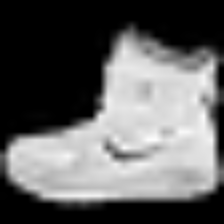

In [8]:
# view data after resizing
for example in data.take(1).as_numpy_iterator():
  print(example.shape)
  cv2_imshow(example[0])

## loading "Caltech 256" dataset from kaggle


In [9]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=ab8ac318c9d2278feeaa6dbc07cab451e9f98723baca69e2b1fc8089372a4660
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [10]:
from google.colab import files

In [ ]:
# you should put here your kaggle.json file with API-key
files.upload()

In [16]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list -s {,,'Caltech 256'}

mkdir: cannot create directory ‘/root/.kaggle’: File exists
No datasets found


In [17]:
!kaggle datasets download -d {,,'jessicali9530/caltech256'} -p /content/kaggle/

100% 2.12G/2.12G [00:24<00:00, 45.2MB/s]
100% 2.12G/2.12G [00:24<00:00, 92.7MB/s]


In [ ]:
!unzip '/content/kaggle/caltech256.zip' -d '/content/kaggle/'

(180, 436, 3)


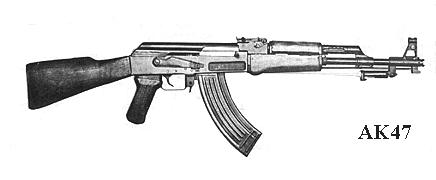

In [19]:
# view the raw data
img = cv.imread('/content/kaggle/256_ObjectCategories/001.ak47/001_0016.jpg')
print(img.shape)
cv2_imshow(img)

In [20]:
tf_dataset_2 = tf.data.Dataset.list_files('/content/kaggle/256_ObjectCategories/*/*', shuffle=False)

In [21]:
def preprocess_image(file_path):
    '''
    use preprocessing image (eg resizing)
    '''
    
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    return img

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE #the numbers of parallel workers choose automatically
data_2 = tf_dataset_2.map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(32) #apply the preprocessing function

# model

In [23]:
from keras.applications.vgg16 import VGG16 
from keras.models import Model

In [24]:
model = VGG16(weights='imagenet', input_shape=(224,224,3))
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

553476096/553467096 [==============================] - 3s 0us/step


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## use our model to MNIST

In [ ]:
#extracting features is too long (read below)
features = model.predict(data.take(100).prefetch(1), verbose=1)

100/100 [==============================] - 1478s 15s/step


In [ ]:
# this cell for writing features in file, for speed upload

# features.tofile('/content/features', sep = ';')

Внимание! 

Из-за того что tf pipeline использует ленивую загрузку, а преподработка картинки забирает много времени - мы извлекаем фичи (картинка -> вектор) из части выборки (100 батчах по 32 картинки).

 Но более того, извлеченные features лежат в файле **features** - который можно загрузить в колаб и **запустить ячейку снизу**, и не ждать даже эту обработку. 

In [26]:
features = np.fromfile('/content/features', sep = ';').reshape(-1, 4096)

In [27]:
print(features.shape)

(3200, 4096)


## use our model to Caltech 256

In [ ]:
# extracting features is too long (read below)
features_2 = model.predict(data_2.take(100).prefetch(1), verbose=1)

100/100 [==============================] - 1486s 15s/step


In [47]:
# this cell for writing features in file, for speed upload

# features_2.tofile('/content/features_2', sep = ';')

Внимание! 

Из-за того что tf pipeline использует ленивую загрузку, а преподработка картинки забирает много времени - мы извлекаем фичи (картинка -> вектор) из части выборки (100 батчах по 32 картинки).

 Но более того, извлеченные features_2 лежат в файле **features_2** - который можно загрузить в колаб и **запустить ячейку снизу**, и не ждать даже эту обработку. 

In [28]:
features_2 = np.fromfile('/content/features_2', sep = ';').reshape(-1, 4096)

In [29]:
print(features_2.shape)

(3200, 4096)


## PCA

In [30]:
pca = PCA(n_components=120, random_state=1)
pca.fit(features)
x = pca.transform(features)

In [31]:
print(x.shape)

(3200, 120)


In [32]:
pca_2 = PCA(n_components=120, random_state=1)
pca_2.fit(features_2)
x_2 = pca_2.transform(features_2)

In [33]:
print(x_2.shape)

(3200, 120)


## clustering

Мы предполагаем, что знаем количество классов для кластеризации заранее (из просмотра сырых данных), если это не так - нужно использовать инной алгоритм для кластеризации (которому не нужно инициализировать количество классов заранее).

Приметка: Для кластеризации Caltech 256 мы используем только 32 классов, т.к. добыли features только для них (мы не перемешивали дополнительно данные, как в mnist). Если прогнать не подвыборку, а всю выборку - можем использовать все 256 классов.

In [34]:
aggl = AgglomerativeClustering(n_clusters=10).fit(x)

In [35]:
labels = aggl.labels_ #the aim of our job
print(labels)

[1 4 2 ... 3 1 8]


In [36]:
aggl_2 = AgglomerativeClustering(n_clusters=32).fit(x_2)

In [37]:
labels_2 = aggl_2.labels_ #the aim of our job
print(labels_2)

[19 19 19 ...  0  2  0]


# Visualization

In [38]:
class Visual():

  '''
  class created for visualization the results of our clustering,
  for visualization call print_class function
  '''

  def __init__(self, labels, data, numb_task):

    '''
    np.array: labels - list of labels from classifier 
    data - dataset with input data
    int: numb_task - 1 (for fashion Mnist) or 2 (for Caltech 256)
    '''

    self.labels = labels
    self.data = data
    self.numb_task = numb_task

  def __indexes_in_dict(self):
    dict_of_labels = {}

    for i in range(10):
      result = np.where(self.labels == i)[0]
      dict_of_labels[str(i)] = result

    return dict_of_labels


  def __create_class_images(self, dict_of_labels, index):
    return [self.data[i] for i in dict_of_labels[str(index)]]


  def print_class(self, index):

    ''' int : index - in range (0-9 for mnist and 0-32 for caltech)
     - the label of class to visualization '''

    if self.numb_task == 1:
      dict_of_labels = self.__indexes_in_dict()
      class_label = self.__create_class_images(dict_of_labels, index)
      for image in class_label:
        cv2_imshow(image)

    elif self.numb_task == 2:
      count = 0
      for example in self.data.take(50).as_numpy_iterator():
        for i in range(32):
          if labels_2[count] == index:
            cv2_imshow(example[i])
          count += 1

    else:
      print("Incorrect numb_task")

In [39]:
visualizer = Visual(labels, train, 1)

In [42]:
# You can set the value "numb_of_class" of class_number
# to see the topics of images that classifier summarized in one class

numb_of_class = 9
visualizer.print_class(numb_of_class)

In [44]:
visualizer_2 = Visual(labels_2, data_2, 2)

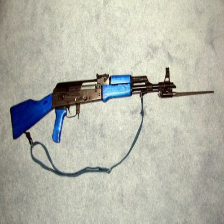

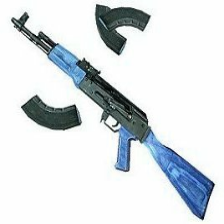

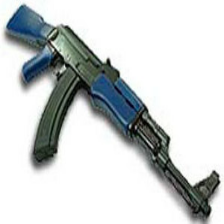

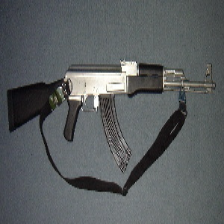

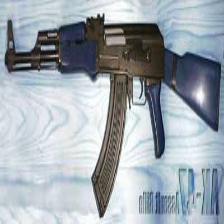

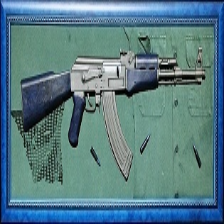

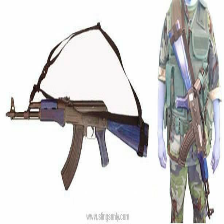

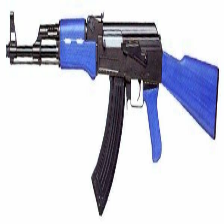

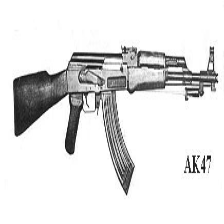

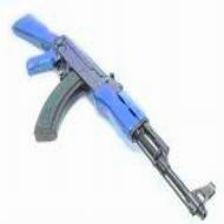

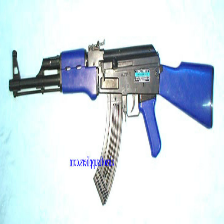

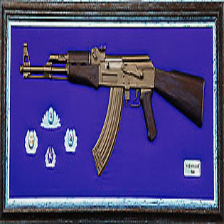

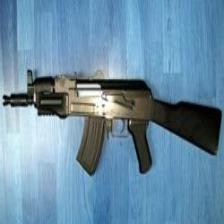

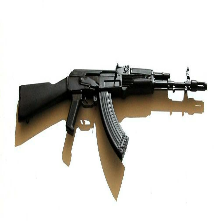

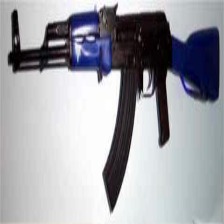

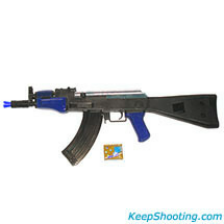

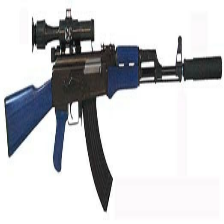

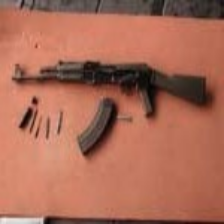

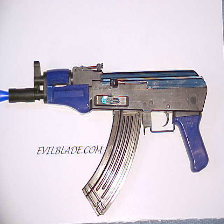

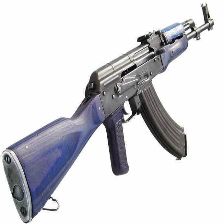

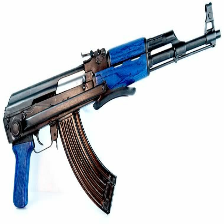

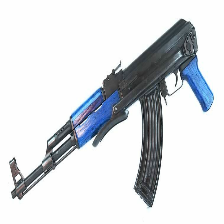

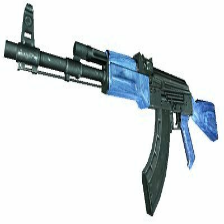

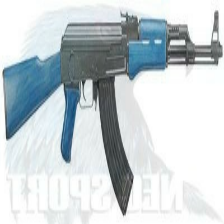

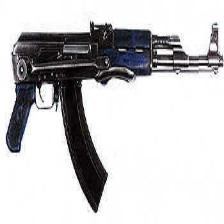

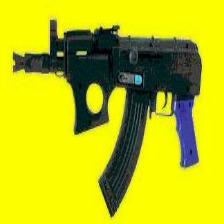

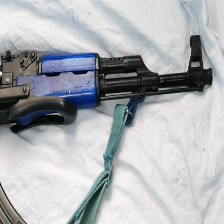

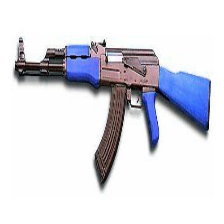

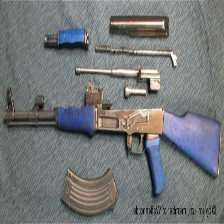

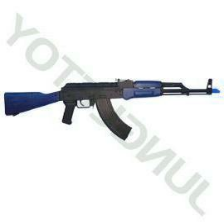

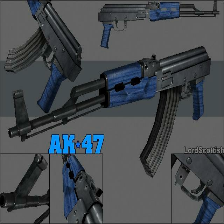

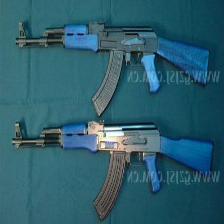

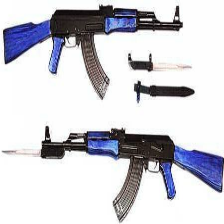

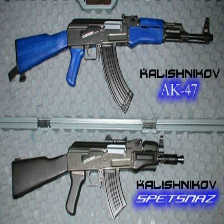

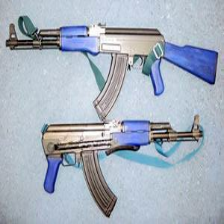

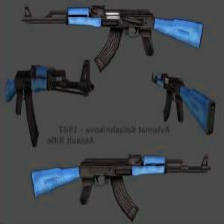

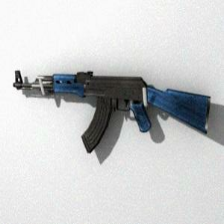

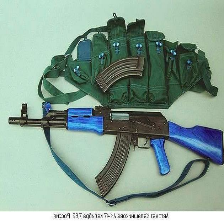

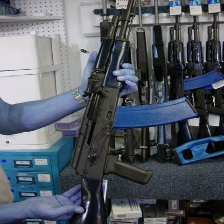

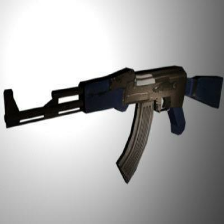

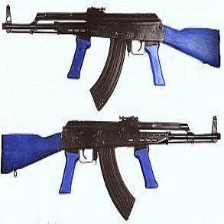

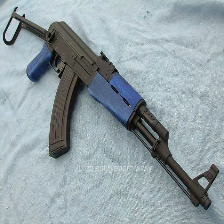

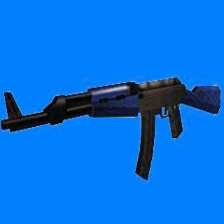

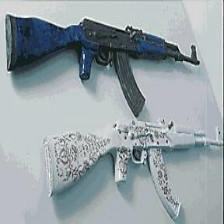

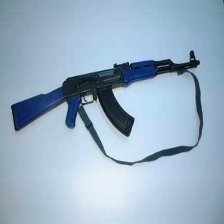

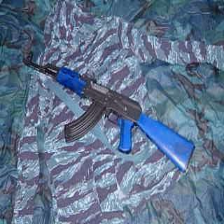

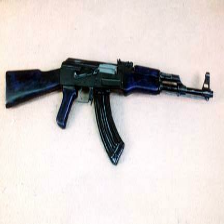

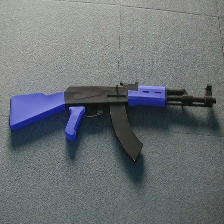

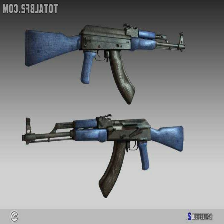

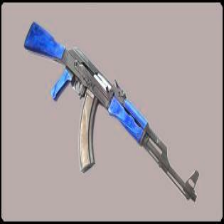

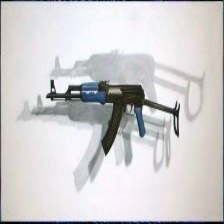

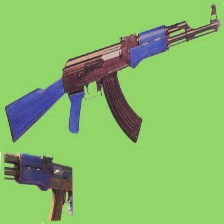

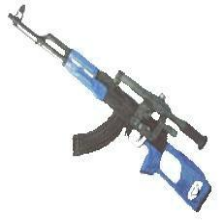

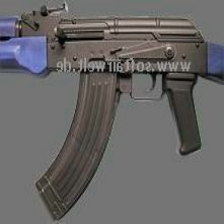

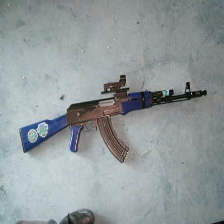

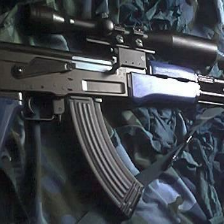

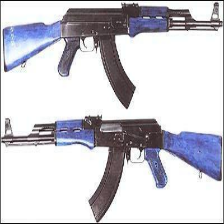

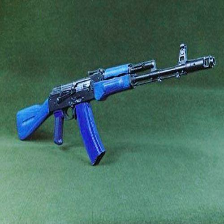

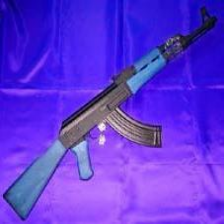

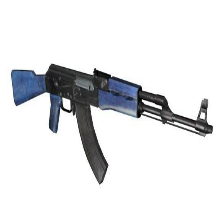

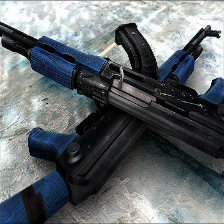

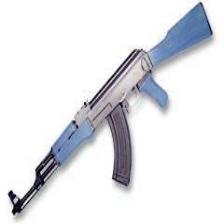

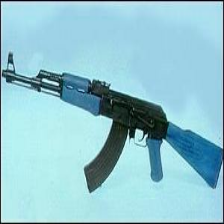

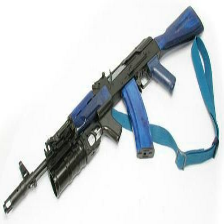

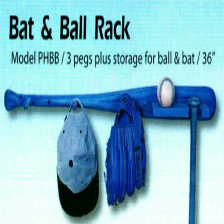

In [46]:
# You can set the value "numb_of_class" of class_number
# to see the topics of images that classifier summarized in one class

numb_of_class = 19
visualizer_2.print_class(numb_of_class)